# Deteccion de edad ósea - Proyecto 2

Alexander Trujillo - 17189

Javier Carpio - 17077

Francisco Molina - 17050

Ana Lucia Hernandez - 17138

Andrea Arguello - 17501

Maria Fernanda Lopez - 17160

## Situación problemática
Por décadas, la determinación de la madurez ósea se ha basado en una evaluación visual del desarrollo esquelético de la mano y la muñeca (Gilsanz y Ratib, 2005). Por lo tanto, sería útil el determinar esta de manera automatizada. Para esto, se cuenta con un conjunto de datos de entrenamiento con 12.6k imágenes de radiografías de infantes, y se provee además su género y su edad, esta última siendo la variable dependiente, ya que el objetivo es, a partir de la radiografía (o la misma y el género), determinar de forma automatizada la edad ósea de los infantes.


## Problema científico
Conocer la edad ósea (EO) de un individuo es necesaria para confirmar el diagnóstico de variantes normales del crecimiento, así como para orientar el diagnóstico de condiciones patológicas, tales como diagnosticar y tratar una multitud de trastornos endocrinos y síndromes pediátricos, para decidir el inicio o el cese de ciertos tratamientos y para estimar la talla adulta, y para estimar la edad de niños con fecha de nacimiento desconocida. Sin embargo, durante décadas, la determinación de la madurez ósea se ha basado en una evaluación visual del desarrollo esquelético de la mano y la muñeca (Gilsanz y Ratib, 2005; Navarro, Tejedor y López Siguero, 2014). 


## Objetivos
### General
Aplicar los conceptos de reconocimiento de imágenes vistos en clase, tanto la limpieza y procesamiento de las mismas como la creación de redes neuronales convolucionales (CNN por sus siglas en inglés), y aplicarlos a situaciones de la vida real (en este caso, en el ámbito de la pediatría).

### Específicos
1. Predecir la edad ósea del paciente, con base en las imágenes provistas de radiografías de manos, con una precisión de $\pm$4.2 meses.
2. Evaluar si incluir el género como variable tiene correlación con la precisión de la edad calculada.


## Descripción de los datos
Los datos a trabajar son los de *RSNA Bone Age* los cuales contienen imagenes de rayos x digitalizadas y escaneadas de la mano de una persona, también se cuenta con un csv en el cual se indica la edad real y genero de dicha imagen, esta edad es la que se predecira con el modelo a elobarar.

Se cuenta con datos de test y de training, cada uno con su respectiva cantidad de imágenes y su propio csv. Como se menciono anteriormente dichos csv contienen dos datos importantes la edad y el genero. Al observar los csv de train y de test podemos observar que la columna en donde se indica el genero no es llamada igual y no se utilizan los mismos datos para describir el sexo. 
En el caso del csv de train podemos observar que la columna para describir el sexo de la persona se llama 'Male' y sus datos son tipo booleano teniendo un 'True' para cuando es hombre y un 'False' para cuando se es mujer. A diferencia de test que podemos observar que esta columna sí se llama 'Sex' y cuenta con dos valores tipo string 'M' para indicar  hombre ('Male' en ingles) y 'F' para indicar mujer ('Female' en ingles). 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

In [ ]:
train = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
print(train.head())

### Limpieza de datos 

Se cambia variable male para que este este en los términos del test dataset y mantener coherencia entre ambos datasets.

In [ ]:
#Limpieza 
train = train.assign(sex = lambda train: train['male'].map(lambda male: "M" if male == True else "F") )
train = train.drop(['male'], axis=1)

In [ ]:
y = train['sex'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Masculino',"Femenino"]
ax.bar(langs,y)
plt.title('Cantidad de hombres y mujeres')
plt.ylabel('Cantidad')
plt.xlabel('Género')

plt.show()

In [ ]:

labels = ['M','F']
explode = (0.2, 0, 0, 0, 0, 0)
plt.pie(train['sex'].value_counts(), labels=labels,
autopct='%1.1f%%', shadow=True)
plt.title('Population Density Index')

plt.title('Population Density Index')
plt.show()

Se observa que los datos están casi equitativamente distribuidos entre hombres y mujeres. Es por ello que no se considera necesario aplicar balanceo de clases de los datos proporcionados por el dataset.

In [ ]:
train.hist('boneage', bins = 10)

Se observa que los datos están principalmente concentrados entre 125  y 175 meses, el histograma presenta sesgo a la izquierda.

In [ ]:
train['boneage'].describe()

In [ ]:
train.boxplot('boneage')

In [ ]:
train.boxplot('boneage', by='sex')

In [ ]:
for img_id, boneage, sex in train[['id','boneage', 'sex']].sample(5).values:
    img_name = str(img_id) + '.png'
    img = mpimg.imread("../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    plt.title('Image: {} Boneage: {} Sex: {}'.format(img_name, boneage, sex))
    plt.show()

Podemos observar en las imágenes que todas las radiografías son de la mano izquierda, esto puede ser al método con el cual se calculó la edad osea. De igual manera se puede ver que la calidad de las radiografías no es igual para todas como se observa en la cuarta imagen que los huesos no se aprecian de igual forma a comparación de las demás en donde estos se ven de un color verde fosforescente.

Al haber imágenes con esta calidad podemos asumir que para la predicción se tendrá que hacer una transformación en la imagen en donde se resalten estos huesos en alguna escala de grises o bien con alguna textura.

In [ ]:
for img_id, boneage, sex in train[['id','boneage', 'sex']].sample(5).values:
    img_name = str(img_id) + '.png'
    im = Image.open("../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+img_name)
    width, height = im.size
    print(width,height) 

Se puede observar además que las imágenes vienen en distintos tamaños, y el tamaño de las mismas es bastante grande.

## Hallazgos y conclusiones 

Debido a que el train set contiene la variable de género como un booleano indicando si es hombre o mujer, fue necesario modificar dicha columna, pues en el test set se encontraba como un string indicando 'M' y 'F' para los mismos.

El dataset contiene una mayor cantidad de observaciones de hombres, sin embargo, la proporción de los mismos es de aproximadamente 54% hombres y 46% mujeres. Debido a que la diferencia no es significativa, no se considera necesario el hacer un aumento de las entradas para emparejar los datos. 

Se puede observar que la edad está dada en meses, con un sesgo a la izquierda, indicando que la mayoría de los datos, al igual que lo que refleja el diagrama de caja y bigote, se encuentran por debajo de los 132 meses (es decir, 11 años). Además, los hombres presentan edades más altas en el dataset, con una mediana de 150, mientras que la mediana de las mujeres se encuentra por debajo de la del dataset completo, aproximadamente por 124-125 meses. Se puede notar, en el diagrama de caja y bigote de todo el dataset, que hay datos atípicos en las edades más bajas, por lo cual el modelo podría tener problemas a la hora de predecir la edad ósea dentro del rango deseado.

Ya que todas las imágenes son de la mano izquierda, no es necesario eliminar fotografías en el dataset, ya que de haber alguna que fuese de la mano derecha, esto podría afectar a la hora de realizar el modelo. 

## Conclusiones sobre los siguientes pasos a seguir

Algunas imágenes se encuentran muy "oscuras", refiriéndose a que los huesos no se distinguen claramente. Será necesario recuperar la información, ya sea cambiando los colores a blanco y negro u obteniendo las derivadas de las mismas para trabajarlas con las texturas.

Será necesario realizar transformaciones sobre las fotos además, debido a las altas dimensiones de las mismas y a que no hay un "estándar" en el conjunto de datos, ya que hay distintos tamaños y dimensiones.

Se planea trabajar con una red neuronal convolucional, debido a que se está trabajando con imágenes.

## Algoritmos de aprendizaje útiles para abordar el problema
### Artificial Neural Network
Con una red de este tipo se pueden realizar análisis multifactoriales. Consiste en una estructura multicapa que contiene nodos conectados por bordes ponderados que establecen una capa de entrada, una o más capas ocultas y una capa de salida. Con valores de entrada y salida conocidos, la red se entrena ajustando los pesos de forma incremental hasta que la salida de la red se aproxima a la salida conocida. Esta red predice de forma eficiente, por lo general es aplicada a la interpretación de imágenes, pero al contrario que en el caso de regresión, se trata de una técnica en donde los resultados no pueden interpretarse de forma intuitiva (Dallora, Anderberg, Kvist, Mendes, Diaz Ruiz, y Berglund, 2019).

### Convolutional Neural Network
Un modelo de clasificación de imágenes de CNN toma una imagen de entrada, la pasa a través de una serie de capas convolucionales, no lineales, agrupadas y completamente conectadas, y finalmente nos da una salida. Una imagen de entrada es básicamente una matriz de píxeles en forma de matriz: h x w x d (h = altura, w = ancho, d = dimensión). Cada imagen de entrada pasará a través de una serie de capas de convolución con filtros. Y en la práctica, una CNN aprende los valores de estos filtros por sí misma durante el proceso de formación. Este filtro se llama "kernel" y también es una matriz de números. Imaginemos que este kernel se desliza por todas las áreas de la imagen de entrada con un ancho de paso predefinido. Este ancho de paso o la distancia que se mueve un kernel cada vez que pasa sobre una imagen se define como un "paso" (Husseini, Spronk, Masanneck, y Gutewort, 2019).

### Bayesian Network
La red bayesiana estima la probabilidad posterior de que un punto de datos sea de una determinada clase, dado un conjunto de características. El proceso de aprendizaje ocurre en dos fases: primero aprende la estructura de la red, que es un gráfico acíclico directo compuesto por nodos (que representan las características) y aristas (que representan las dependencias probabilísticas), luego aprende la distribución de probabilidad condicional de cada nodo. Las ventajas de las redes bayesianas son que pueden codificar el conocimiento de los expertos en el dominio en la estructura del gráfico y pueden trabajar con cantidades más pequeñas de datos. Una gran desventaja es que las redes bayesianas pueden volverse poco prácticas en problemas con un gran número de variables (Dallora, Anderberg, Kvist, Mendes, Diaz Ruiz, y Berglund, 2019).

## Algoritmo a utilizar
Se utilizarán modelos de una red convolucional, el motivo de haber elegido una red convolucional es debido a su manejo de los pixeles y cuadros de la imagen que puede tener debido a la arquitectura que esta tiene que fue explicada anteriormente, y ya que, según el laboratorio realizado en clase, es mejor que una ANN para los problemas de análisis de imágenes.


## Lectura y preparación de imagenes

Método obtenido de https://www.kaggle.com/dansbecker/tensorflow-programming

In [2]:
%pip install tensorflow

  Using cached tensorflow-2.3.1-cp38-cp38-macosx_10_14_x86_64.whl (165.2 MB)
  Using cached protobuf-3.13.0-cp38-cp38-macosx_10_9_x86_64.whl (1.3 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-0.10.0-py3-none-any.whl (127 kB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached numpy-1.18.5-cp38-cp38-macosx_10_9_x86_64.whl (15.1 MB)
Processing /Users/polaris/Library/Caches/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501/termcolor-1.1.0-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.32.0-cp38-cp38-macosx_10_9_x86_64.whl (3.3 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
Processing /Users/polaris/Library/Caches/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73/wrapt-1.12.1-cp38-cp38-macosx_1

In [5]:
from IPython.display import Image, display
# from learntools.deep_learning.decode_predictions import decode_predictions
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from os.path import join
from os import listdir
import pandas as pd
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
def read_and_prep_images(img_paths, img_height, img_width, color_mode="grayscale"):
    imgs = [load_img(img_path, target_size=(img_height, img_width, 1), color_mode=color_mode) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return(img_array)

In [ ]:
# obtener todos los paths de los archivos 

base_path = '../input/rsna-bone-age/'

train_imgs = [ [int(file.split(".")[0]), join(base_path + ("boneage-training-dataset/"*2), file)] for file in listdir(base_path + ("boneage-training-dataset/"*2)) ]
# test_imgs = [ [int(file.split(".")[0]), join(base_path + ("boneage-test-dataset/"*2), file)] for file in listdir(base_path + ("boneage-test-dataset/"*2)) ]

# obtener train y test dfs
train_imgs_df = pd.DataFrame(train_imgs, columns = ["id", "path"])
# test_imgs_df = pd.DataFrame(test_imgs, columns = ["id", "path"])

train_csv = pd.read_csv('../input/rsna-bone-age/boneage-training-dataset.csv')
# train_csv = train_csv.assign(sex = lambda train: train['male'].map(lambda male: "M" if male == True else "F") )
# train_csv = train_csv.drop(['male'], axis=1) # No la droppeamos ya que más adelante queremos ver si nos ayuda tener el género

# test_csv = pd.read_csv('../input/rsna-bone-age/boneage-test-dataset.csv').rename(columns={"Case ID": "id", "Sex":"sex"})

data = train_imgs_df.merge(train_csv, on="id", how="inner")
# test = test_imgs_df.merge(test_csv, on="id", how="inner")

Ahora se hará el split de la data, en 65% para training y 35% de testing.

In [ ]:
train, test = np.split(data.sample(frac=1), [int(.65*len(data))])

Seguidamente, se realizará el procesamiento de imágenes tanto para el segmento de training como para testing

In [ ]:
img_size = 300
#X_train = read_and_prep_images(train["path"].values, img_height = img_size, img_width = img_size)
y_train = train['boneage'].values

In [ ]:
#X_test = read_and_prep_images(test["path"].values, img_height = img_size, img_width = img_size)
y_test = test['boneage'].values

In [ ]:
# save de las matrices de train y test, solo de la matriz X ya que eso es lo que mas se tarda
#with open('X_train_2.npy', 'wb') as f:
#    np.save(f, X_train)
#with open('X_test_2.npy', 'wb') as f:
#    np.save(f, X_test)

In [6]:
# load de las matrices
# X_train = np.load(r'./X_train.npy')
# X_test = np.load(r'./X_test.npy')
with open('X_train.npy', 'rb') as f: #idk about this porque no sé si el X_train se guarda como var global
   X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
   X_test = np.load(f)

In [7]:
Y_train = np.load(r'./y_train.npy')
Y_test = np.load(r'./y_test.npy')

In [8]:
train_x = X_train[:1000]
train_y = Y_train[:1000]
test_x = X_test[:500]
test_y = Y_test[:500]

In [8]:
img_size = 300

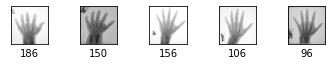

In [11]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(train_y[i])
plt.show()

## Convolutional Neural Network
A diferencia del laboratorio realizado, este no es un problema de clasificación, sino de regresión, ya que queremos predecir la edad ósea en meses, una variable cuantitativa y no categórica.

In [12]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=(img_size, img_size,1)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='relu'))

In [15]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])

In [16]:
model.fit(train_x, train_y, epochs=10, validation_data=(test_x, test_y))

Epoch 1/10
32/32 [==============================] - 140s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 2/10
32/32 [==============================] - 134s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 3/10
32/32 [==============================] - 135s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 4/10
32/32 [==============================] - 143s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 5/10
32/32 [==============================] - 139s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 6/10
32/32 [==============================] - 144s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 18284.7207 - val_mse: 18284.7207
Epoch 7/10
32/32 [==============================] - 140s 4s/step - loss: 17367.4844 - mse: 17367.4844 - val_loss: 1828

In [20]:
results = model.evaluate(test_x, test_y)
print("\nMSE: %.2f" % (results[1]))

16/16 [==============================] - 14s 863ms/step - loss: 18284.7207 - mse: 18284.7207

MSE: 18284.72


In [27]:
model.save('modelosimple.h5')

In [ ]:
model_og = Sequential()

model_og.add(Conv2D(16, kernel_size=(5, 5), activation='relu',input_shape=(img_size, img_size,1)))
model_og.add(Dropout(rate = 0.25))

model_og.add(Conv2D(32, (5, 5), activation='relu'))
model_og.add(Dropout(rate = 0.25))
model_og.add(Conv2D(64, (3, 3), activation='relu'))
model_og.add(Conv2D(128, (3, 3), activation='relu'))
model_og.add(Dropout(rate = 0.25))
model_og.add(Flatten())
model_og.add(Dense(256, activation='relu'))
model_og.add(Flatten())
model_og.add(Dense(1, activation='softmax'))

In [1]:
from keras.models import load_model
model = load_model('modelosimple.h5')
model_og = load_model('modelo_cnn.h5')

In [26]:
results_og = model_og.evaluate(test_x, test_y)
print("\nMSE: %.2f" % (results_og[2]))

16/16 [==============================] - 19s 1s/step - loss: 18027.9434 - accuracy: 0.0000e+00 - mean_squared_error: 18027.9434

MSE: 18027.94


Epoch 1/5
32/32 [==============================] - 139s 4s/step - loss: 17367.4844 - mean_squared_error: 17367.4844 - val_loss: 18284.7207 - val_mean_squared_error: 18284.7207
Epoch 2/5
32/32 [==============================] - 146s 5s/step - loss: 17367.4824 - mean_squared_error: 17367.4824 - val_loss: 18284.7207 - val_mean_squared_error: 18284.7207
Epoch 3/5
32/32 [==============================] - 145s 5s/step - loss: 17367.4844 - mean_squared_error: 17367.4844 - val_loss: 18284.7207 - val_mean_squared_error: 18284.7207
Epoch 4/5
32/32 [==============================] - 154s 5s/step - loss: 17367.4844 - mean_squared_error: 17367.4844 - val_loss: 18284.7207 - val_mean_squared_error: 18284.7207
Epoch 5/5
32/32 [==============================] - 147s 5s/step - loss: 17367.4844 - mean_squared_error: 17367.4844 - val_loss: 18284.7207 - val_mean_squared_error: 18284.7207


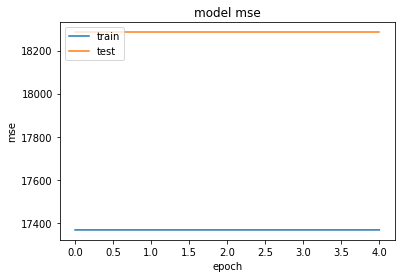

In [15]:
from matplotlib import pyplot as plt
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/5
32/32 [==============================] - 945s 30s/step - loss: 17117.6953 - accuracy: 0.0000e+00 - mean_squared_error: 17117.6953 - val_loss: 18027.9434 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 18027.9434
Epoch 2/5
32/32 [==============================] - 2248s 70s/step - loss: 17117.6953 - accuracy: 0.0000e+00 - mean_squared_error: 17117.6953 - val_loss: 18027.9434 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 18027.9434
Epoch 3/5
32/32 [==============================] - 981s 31s/step - loss: 17117.6953 - accuracy: 0.0000e+00 - mean_squared_error: 17117.6953 - val_loss: 18027.9434 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 18027.9434
Epoch 4/5
32/32 [==============================] - 1190s 37s/step - loss: 17117.6953 - accuracy: 0.0000e+00 - mean_squared_error: 17117.6953 - val_loss: 18027.9434 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 18027.9434
Epoch 5/5
32/32 [==============================] - 973s 30s/step - loss: 17117.6953 - accu

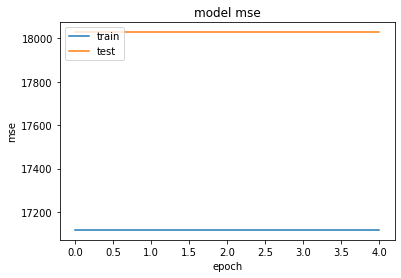

In [9]:
from matplotlib import pyplot as plt
history = model_og.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Hallazgos y conclusiones entrega #2

Para esta primera entrega nos enfocamos en comprender el dataset y planear como lo ibamos a manegar e interpretar para sacar resultados, al final decimos crear unas redes neuronales que comprendiar el dataset, para esto nos inspiramos en otras redes neuronales en internet que hacian cosas parecidas, pero a partir de este paso empezamos a tener algunas complicaciones que se detallaran en breve. 

Cuando pusimos a correr los modelos con los datos ya entrenados y testeados pero se obtuvieron resultados mixtos, ya que muchas complicaciones se nos presentaron, por ejemplo el dataset que se uso era muy pesado lo que provoco que la mayoria de las computdoras del grupo no pudieran prosesarlo a la hora de correr el modelo, por lo que intentamos usar una menor cantidad de datos para hacerlo mas ligero pero esto tambien nos dio malos resultados porque el accuracy que nos devolvia era de 0.00% ya que la cantidad de datos no era suficiente para poder tener mas acurracy, por lo que tampoco pudimos quedarnos con estos resultados, al final lo que se tuvo que hacer fue tomar una computadora mas potente la cual si pudo procesarlo aunque igual hay que recalcar que le llevo 10 minutos hacerlo.

Después intentamos usar una red neuronal más simple la cual saco resultados parecidos a la compleja, por lo que para el resto del proyecto estaremos usando esta, de igual manera para tener mejores resultados seria mejor usar la compleja pero tomar en cuanta que esto solo si se tiene una computadora con un nivel alto de procesamiento.

## Referencias
1. Gilsanz, V. y Ratib, O. (2005). _Hand Bone Age_. Berlín: Springer.
2. Dallora, A. L., Anderberg, P., Kvist, O., Mendes, E., Diaz Ruiz, S. y Berglund, J. S. (2019). Bone age assessment with various machine learning techniques: A systematic literature review and meta-analysis. _PLoS ONE_, 14(7): e0220242. Disponible en: https://doi.org/10.1371/journal.pone.0220242
3. Husseini, H., Spronk, T., Masanneck, L. y Gutewort, L. (2019). Bone age prediction through x-ray images. _Medium_. Recuperado de https://medium.com/techlabsms/bone-age-prediction-through-x-ray-images-6e181d900a7a
4. Navarro, M. M., Tejedor, B. M. y López Siguero, J. P. (2014) “El uso de la edad ósea en la práctica clínica”, _Anales de Pediatría Continuada_, 12(6), pp. 275–283. doi: 10.1016/s1696-2818(14)70204-5. Disponible en: https://www.elsevier.es/es-revista-anales-pediatria-continuada-51-articulo-el-uso-edad-osea-practica-S1696281814702045